In [50]:
import os,sys
from time import time
import numpy as np
import scipy.spatial
import matplotlib.pylab as plt
from scipy import interpolate
from IPython.display import display, HTML
from matplotlib import gridspec
#import postprocess as ps

In [51]:
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['font.family']="serif"
plt.rc("text", usetex=True)
plt.rc("font", size=22)

In [52]:
'''
Takes in a set of halo positions and returns the CDF of the distance to the kth nearest neighbour

halo_pos: array of shape (n_halos, 3) containing the positions of the halos
boxsize: size of the box in Mpc/h
target_number_density: the number density of halos to sample (this choice will depend on the scales of interest -
                                                              the default number density here will be for data vectors 
                                                              that are well-measured in the (rmin, rmax) range of
                                                              1-40 Mpc/h)
rmin: minimum distance in the data vector (in Mpc/h)
rmax: maximum distance in the data vector (in Mpc/h)
nbin: number of bins in the data vector
n_query_points: number of query points to use to calculate the CDF
k_list: list of k values to calculate the CDF for
'''


def get_knn_data_vector(halo_pos, boxsixe=256, 
                        target_number_density = 1e-4, rmin = 1, rmax =  40, nbin = 80,
                        n_query_points = 4000000, k_list = [1,2,3,4]):
    
    #Define the bins - equally spaced between rmin and rmax
    bins = np.linspace(rmin, rmax, nbin)
    
    #Create the data vector - CDF of query points for each k in k_list
    knn_data_vector = np.zeros((nbin, len(k_list)))
    
    #Check that the number density is correct
    n_halos = len(halo_pos)
    halo_number_density = n_halos / boxsixe**3
    print('Halo number density: ', halo_number_density)
    
    if halo_number_density>target_number_density:
        ind = np.random.choice(n_halos, int(n_halos * target_number_density / halo_number_density), replace=False)
        halo_pos = halo_pos[ind]
    
    
    query_pos = np.random.rand(n_query_points, 3) * boxsixe
    tree = scipy.spatial.cKDTree(halo_pos,boxsize=boxsixe)
    dist, ind = tree.query(query_pos, k=k_list, workers=-1)
    
    for k in k_list:
        dist_list = dist[:, k-1]
        ind = np.argsort(dist_list)
        dist_list = dist_list[ind]
        
        #Calculate the CDF at each bin
        knn_data_vector[:, k-1] = np.searchsorted(dist_list, bins) / n_query_points
        
    
    return bins, knn_data_vector

### Test 1 : Number density higher than set threshold

Use a randomly distributed set of 20000 points in the box 

In [53]:
pos = np.random.rand(50000, 3) * 256
bins, knn_data_vector = get_knn_data_vector(pos)

Halo number density:  0.0029802322387695312


(0.0, 35.0)

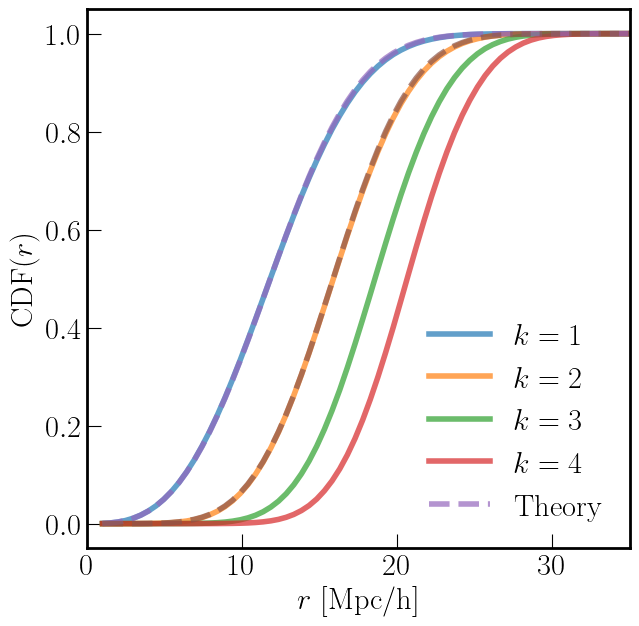

In [54]:
number_density = 1e-4

plt.plot(bins, knn_data_vector[:, 0], label=r'$k=1$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 1], label=r'$k=2$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 2], label=r'$k=3$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 3], label=r'$k=4$', lw = 4, alpha = 0.7)

plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3), label=r'Theory', lw = 4, ls = '--', alpha = 0.7)
plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3) - 
         number_density*4./3. * np.pi *bins**3 * np.exp(-number_density*4./3. * np.pi *bins**3)
         , lw = 4, ls = '--', alpha = 0.7)

plt.legend()
plt.xlabel(r'$r$ [Mpc/h]')
plt.ylabel(r'${\rm CDF}(r)$')

plt.xlim(0, 35)


### Test with a lower number density than threshold

Use 1000 points over the entire volume

In [55]:
pos = np.random.rand(1000, 3) * 256
bins, knn_data_vector = get_knn_data_vector(pos)

Halo number density:  5.9604644775390625e-05


(0.0, 35.0)

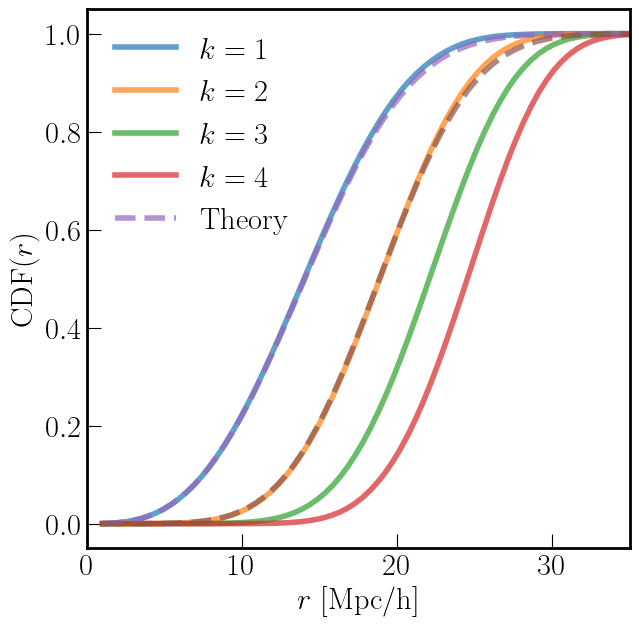

In [56]:
number_density = 1000 / 256**3

plt.plot(bins, knn_data_vector[:, 0], label=r'$k=1$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 1], label=r'$k=2$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 2], label=r'$k=3$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 3], label=r'$k=4$', lw = 4, alpha = 0.7)

plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3), label=r'Theory', lw = 4, ls = '--', alpha = 0.7)
plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3) - 
         number_density*4./3. * np.pi *bins**3 * np.exp(-number_density*4./3. * np.pi *bins**3)
         , lw = 4, ls = '--', alpha = 0.7)

plt.legend()
plt.xlabel(r'$r$ [Mpc/h]')
plt.ylabel(r'${\rm CDF}(r)$')

plt.xlim(0, 35)


### Additional check at larger boxsize

In [57]:
pos = np.random.rand(100000,3)*1000.
bins, knn_data_vector = get_knn_data_vector(pos, boxsixe=1000,)


Halo number density:  0.0001


(0.0, 35.0)

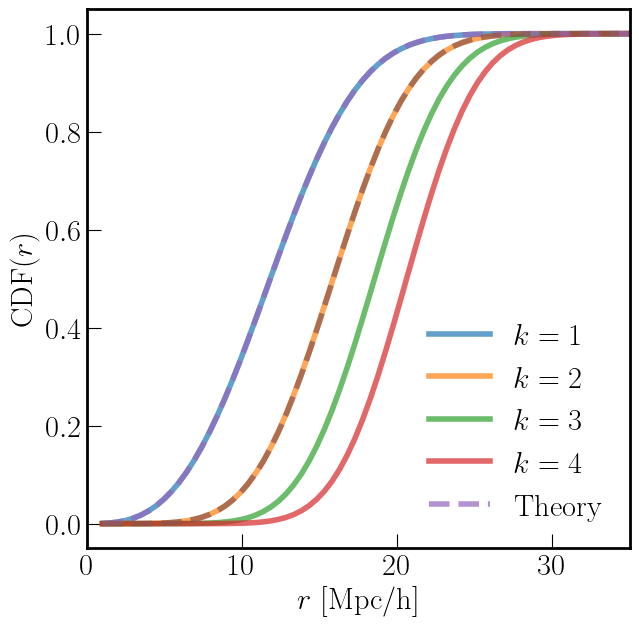

In [58]:
number_density = 1e-4

plt.plot(bins, knn_data_vector[:, 0], label=r'$k=1$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 1], label=r'$k=2$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 2], label=r'$k=3$', lw = 4, alpha = 0.7)
plt.plot(bins, knn_data_vector[:, 3], label=r'$k=4$', lw = 4, alpha = 0.7)

plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3), label=r'Theory', lw = 4, ls = '--', alpha = 0.7)
plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3) - 
         number_density*4./3. * np.pi *bins**3 * np.exp(-number_density*4./3. * np.pi *bins**3)
         , lw = 4, ls = '--', alpha = 0.7)

plt.legend()
plt.xlabel(r'$r$ [Mpc/h]')
plt.ylabel(r'${\rm CDF}(r)$')

plt.xlim(0, 35)

### Test the jack-knife extension

In [100]:
def is_perfect_power(number,power):
    """
    Indicates (with True/False) if the provided number is a perfect power.
    """
    number = abs(number)  # Prevents errors due to negative numbers
    return round(number ** (1 / power)) ** power == number

def add_pbc_jncol(data,rand=None,Lbox=200,njn=0,los=1):
   '''If the input is a periodic box and los is along z axis then jacknife region is simply equal area region in the x-y space which can be done in using this function and not needed to be supplied with data file.
   If njn is perfect cube then 3d jacknife is implemented
   If njn is perfect square then jn split is in x-y plane
   '''


   if(is_perfect_power(njn,3)):
       jntype='3d'
       NJNx=int(np.round(njn ** (1. / 3)))
       NJNy=NJNx;NJNz=NJNx
       print('Using 3d Jacknife:', NJNx, NJNy, NJNz)
   elif(is_perfect_power(njn,2)):
       jntype='2d'
       NJNx=int(np.sqrt(njn))
       NJNy=int(njn/NJNx)
       print('Using 2d Jacknife:', NJNx, NJNy)
   else:
       print('''error: njn must be either a perfect square or perfect cube''')
       sys.exit()

   #adding jacknife regions
   if(njn>0 and los==1):
      POS_min=[0,0,0]; POS_max=[Lbox,Lbox,Lbox];blen=POS_max
      #POS_min,POS_max, blen=getminmax(data,rand=rand)
      #NJNx=int(np.sqrt(args.njn))
      #NJNy=int(args.njn/NJNx)
      for ii in range(0,2):
         if(ii==0): 
             mat=data
         elif(rand is None):
             continue
         else:
             mat=rand

         #get the x and y indx as integers
         indx=np.zeros(mat[:,0].size,dtype=int)
         indy=np.zeros(mat[:,0].size,dtype=int)

         for kk in range(0,indx.size):
             indx[kk]=int(NJNx*(mat[kk,0]-POS_min[0])/blen[0])
             indy[kk]=int(NJNy*(mat[kk,1]-POS_min[1])/blen[1])
         #apply modulo operation on x an y index
         indx=np.mod(indx,NJNx)
         indy=np.mod(indy,NJNy)

         if(jntype=='2d'):
            jnreg=NJNy*indx+indy
         elif(jntype=='3d'):
            indz=np.int_(NJNz*(mat[:,2]-POS_min[2])/blen[2])
            indz=np.mod(indz,NJNz)
            jnreg=NJNz*(NJNy*indx+indy)+indz

         #convert index to integers
         #indx.astype(np.int64); indy.astype(np.int64);
         mat=np.column_stack([mat,jnreg])

         if(ii==0): data=mat
         else: rand=mat
      return data,rand
   else:
      print('not appropriate input to add jacknife internally')
      #sys.exit()
      return 0



In [ ]:
'''
Takes in a set of halo positions and returns the CDF of the distance to the kth nearest neighbour

halo_pos: array of shape (n_halos, 3) containing the positions of the halos
boxsize: size of the box in Mpc/h
target_number_density: the number density of halos to sample (this choice will depend on the scales of interest -
                                                              the default number density here will be for data vectors 
                                                              that are well-measured in the (rmin, rmax) range of
                                                              1-40 Mpc/h)
rmin: minimum distance in the data vector (in Mpc/h)
rmax: maximum distance in the data vector (in Mpc/h)
nbin: number of bins in the data vector
n_query_points: number of query points to use to calculate the CDF
k_list: list of k values to calculate the CDF for
njn: number of jackknife regions to use
los: line of sight 


The function will return a data vector of shape (nbin, len(k_list), njn+4) where the first two indices are the bin and k value respectively.
Note that the second index plays a different role compared to the VVF.
'''


def get_knn_data_vector_jkn(halo_pos, boxsize=256, 
                            target_number_density = 1e-4, rmin = 1, rmax =  40, nbin = 20,
                            n_query_points = 4000000, k_list = [1,2,3,4],
                            njn=125, los=1):
    
    #Define the bins - equally spaced between rmin and rmax
    bins = np.linspace(rmin, rmax, nbin)
    
    
    #Create the jackknifed data vector
    knn_data_vector_jk = np.zeros((nbin, len(k_list), njn+4),dtype=float)
    print (knn_data_vector_jk.shape)
    for k in k_list:
        knn_data_vector_jk[:,k-1,0] = bins
    
    #Check that the number density is correct
    n_halos = len(halo_pos)
    halo_number_density = n_halos / boxsize**3
    print('Halo number density: ', halo_number_density)
    
    if halo_number_density>target_number_density:
        ind = np.random.choice(n_halos, int(n_halos * target_number_density / halo_number_density), replace=False)
        halo_pos = halo_pos[ind]
    
    
    query_pos = np.random.rand(n_query_points, 3) * boxsize
    tree = scipy.spatial.cKDTree(halo_pos,boxsize=boxsize)
    dist, ind = tree.query(query_pos, k=k_list, workers=-1)
    
    for k in k_list:
        dist_list = dist[:, k-1]
        ind = np.argsort(dist_list)
        dist_list = dist_list[ind]
        
        #Calculate the CDF at each bin
        knn_data_vector_jk[:, k-1, 1] = np.searchsorted(dist_list, bins) / n_query_points
    
    query_pos_j,_=add_pbc_jncol(query_pos,rand=None,Lbox=boxsize,njn=njn,los=1)
    
    for j_counter in range (njn):
        print ('j_counter:', j_counter)
        index_mask = query_pos_j[:,-1] != j_counter
        dist_mask = dist[index_mask]
        query_pos_mask = query_pos_j[index_mask]
        n_query_points_mask = len(query_pos_mask)
        
    
        for k in k_list:
            dist_list = dist_mask[:, k-1]
            ind = np.argsort(dist_list)
            dist_list = dist_list[ind]
            
            #Calculate the CDF at each bin
            knn_data_vector_jk[:, k-1, j_counter+4] = np.searchsorted(dist_list, bins) / n_query_points_mask
            
    #Calculate the mean and std of the jackknifed data vector
    #for k in k_list:
    knn_data_vector_jk[:, :, 2] = np.mean(knn_data_vector_jk[:, :, 4:], axis=2)
    knn_data_vector_jk[:, :, 3] = np.sqrt(njn-1)*np.std(knn_data_vector_jk[:, :, 4:], axis=2)
    
        
    
    return knn_data_vector_jk

In [ ]:
njn=125
pos = np.random.rand(100000,3)*1000.
knn_data_vector = get_knn_data_vector_jkn(pos, boxsize=1000,)


(20, 4, 129)
Halo number density:  0.0001
Using 3d Jacknife: 5 5 5
j_counter: 0
j_counter: 1
j_counter: 2
j_counter: 3
j_counter: 4
j_counter: 5
j_counter: 6
j_counter: 7
j_counter: 8
j_counter: 9
j_counter: 10
j_counter: 11
j_counter: 12
j_counter: 13
j_counter: 14
j_counter: 15
j_counter: 16
j_counter: 17
j_counter: 18
j_counter: 19
j_counter: 20
j_counter: 21
j_counter: 22
j_counter: 23
j_counter: 24
j_counter: 25
j_counter: 26
j_counter: 27
j_counter: 28
j_counter: 29
j_counter: 30
j_counter: 31
j_counter: 32
j_counter: 33
j_counter: 34
j_counter: 35
j_counter: 36
j_counter: 37
j_counter: 38
j_counter: 39
j_counter: 40
j_counter: 41
j_counter: 42
j_counter: 43
j_counter: 44
j_counter: 45
j_counter: 46
j_counter: 47
j_counter: 48
j_counter: 49
j_counter: 50
j_counter: 51
j_counter: 52
j_counter: 53
j_counter: 54
j_counter: 55
j_counter: 56
j_counter: 57
j_counter: 58
j_counter: 59
j_counter: 60
j_counter: 61
j_counter: 62
j_counter: 63
j_counter: 64
j_counter: 65
j_counter: 66
j_cou

(0.0, 35.0)

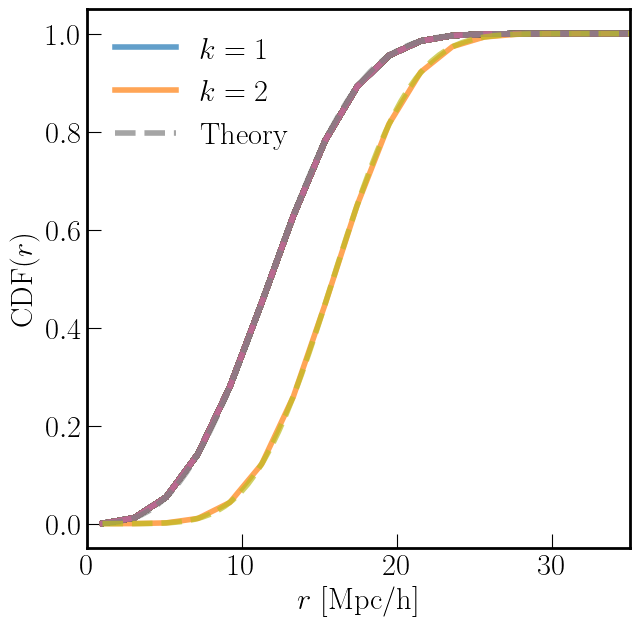

In [122]:


plt.plot(knn_data_vector[:,0, 0], knn_data_vector[:,0, 1], label=r'$k=1$', lw = 4, alpha = 0.7)
plt.plot(knn_data_vector[:,0, 0], knn_data_vector[:,1, 1], label=r'$k=2$', lw = 4, alpha = 0.7)

for i in range(njn):
    plt.plot(knn_data_vector[:,0, 0], knn_data_vector[:,0, i+4], lw = 4, alpha = 0.5)

plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3), label=r'Theory', lw = 4, ls = '--', alpha = 0.7)
plt.plot(bins, 1 - np.exp(-number_density*4./3. * np.pi *bins**3) - 
         number_density*4./3. * np.pi *bins**3 * np.exp(-number_density*4./3. * np.pi *bins**3)
         , lw = 4, ls = '--', alpha = 0.7)

plt.legend()
plt.xlabel(r'$r$ [Mpc/h]')
plt.ylabel(r'${\rm CDF}(r)$')

plt.xlim(0, 35)

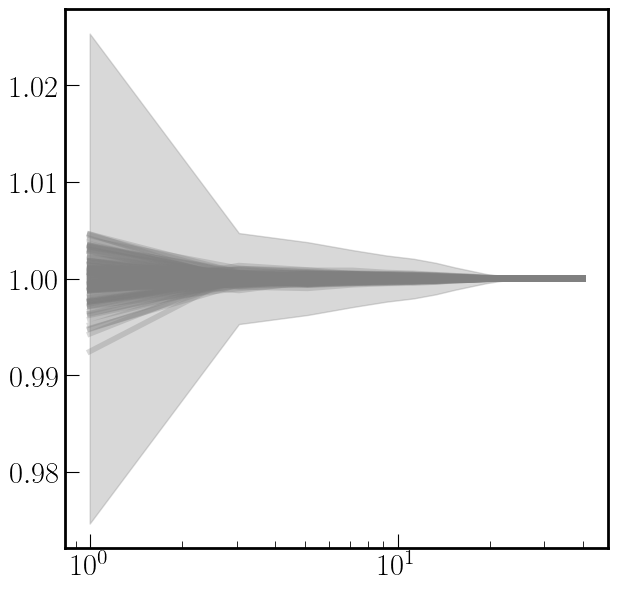

In [118]:
for i in range(njn):
    plt.plot(knn_data_vector[:,0, 0], knn_data_vector[:,0, i+4]/knn_data_vector[:,0, 2], label=r'$k=1$', lw = 4, alpha = 0.3, c= 'gray')   

plt.fill_between(knn_data_vector[:,0, 0], 
                 (knn_data_vector[:,0, 2]-knn_data_vector[:,0, 3])/knn_data_vector[:,0, 2],
                 (knn_data_vector[:,0, 2]+knn_data_vector[:,0, 3])/knn_data_vector[:,0, 2] , alpha = 0.3, color='gray')
plt.xscale('log')